<a href="https://colab.research.google.com/github/jcestevezc/Deep-Learning/blob/main/Laboratorio%20I%20-%20Perceptron%20-%20Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)
# Análisis con deep learning

## Laboratorio I - Neumonia en pulmones

---

#### Integrantes:

- Daniel Cuellar

- Federico Urbina

- Juan Camilo Estevez

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
print('Tensorflow version:', tf.__version__)


from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from skimage import io, color, exposure, feature
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from tqdm.auto import tqdm
import cv2
import os
from sklearn.metrics import (confusion_matrix, precision_score, accuracy_score,
                             recall_score, classification_report)

Tensorflow version: 2.6.0


### **1. Entendimiento de los datos**

### **0. Lectura de los datos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Analisis con deep learning/Laboratorio 1/chest_xray.zip"

Archive:  /content/drive/MyDrive/Analisis con deep learning/Laboratorio 1/chest_xray.zip
replace chest_xray/test/NORMAL/IM-0001-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


La identificación de neumonia y otras enfermedades a partir de imagenes medicas como radiografias, es una de las principales aplicaciones de deep learning.
Para este taller en particular se nos presentan dos grandes conjuntos de imagenes uno correspondiente a radiografias de personas que no presentan neumonía y otro conjunto de imagenes en las que si se puede identificar el padecimiento.
Teniendo en cuenta lo anterior se requiere desarrollar un modelo de clasificación que permita identificar a partir de una imagen medica si los paciendes padecen o no neumonía.

A continuación, se muestran las imagenes correspondientes a personas con y sin neumonía:


#### **1.1. Imagenes normales**

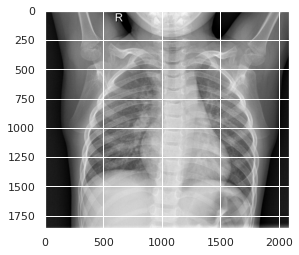

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
%matplotlib inline

img = load_img('/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg') 
x = img_to_array(img)
plt.imshow(img)

#### **1.2. Imagenes neumonía**

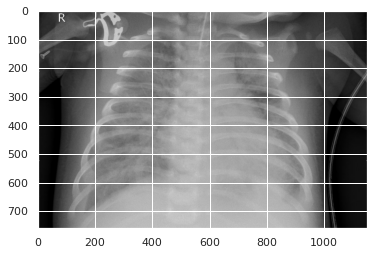

In [ ]:
img = load_img('/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg')
x = img_to_array(img) 
plt.imshow(img)

### **2. Perfilamiento de los datos**

Los datos para el laboratorio se dividen en dos datasets: el primero contiene los datos entrenamiento y el segundo los de prueba. Como se observa a continuación, tanto los datos de entrenamiento como los de test estan desbalanceados. Lo cual en este caso en particular favorece la identificación de la clase de interes que es los pacientes que padecen neumonía.

#### **2.1 Datos entrenamiento**

In [ ]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()
import utils.general as gen


data_dir_train = gen.create_and_verify(
    "chest_xray/train", list_=True
)

data_dir_test = gen.create_and_verify(
    "chest_xray/test", list_=True
)

  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [ ]:
data_counts_train = {
    "Label": [
        "NORMAL",
        "PNEUMONIA"
    ],
    "Counts": [
        len(gen.read_listdir(data_dir_train[0])),
        len(gen.read_listdir(data_dir_train[1]))
    ]
}

data_counts_train = pd.DataFrame(data_counts_train)

In [ ]:
data_counts_train.head()

,Label,Counts
0,NORMAL,1349
1,PNEUMONIA,3883


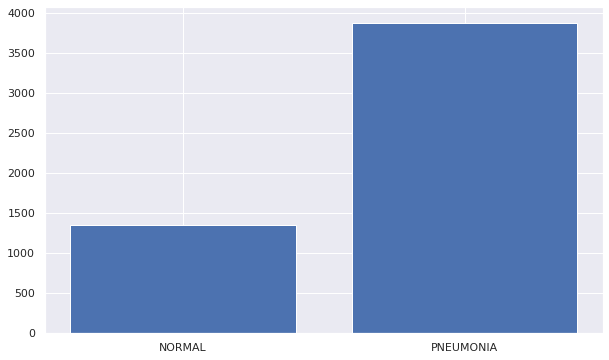

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x=data_counts_train["Label"], height=data_counts_train["Counts"])
plt.show()

#### **2.1 Datos test**

In [ ]:
data_counts_test = {
    "Label": [
        "NORMAL",
        "PNEUMONIA"
    ],
    "Counts": [
        len(gen.read_listdir(data_dir_test[0])),
        len(gen.read_listdir(data_dir_test[1]))
    ]
}

data_counts_test = pd.DataFrame(data_counts_test)

In [ ]:
data_counts_test.head()

,Label,Counts
0,NORMAL,234
1,PNEUMONIA,390


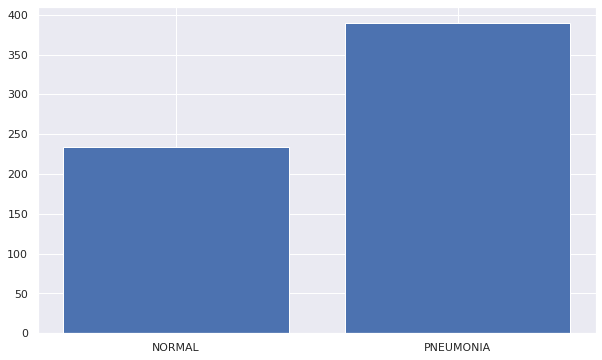

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x=data_counts_test["Label"], height=data_counts_test["Counts"])
plt.show()

### **3. Preparación de datos**

#### **3.1 Versión normal (N)**

In [ ]:
data_dirs_train = []

for dir_ in data_dir_train:
    data_dirs_train.extend(gen.read_listdir(dir_))
data_dirs_train = np.array(data_dirs_train)

data_dirs_test = []

for dir_ in data_dir_test:
    data_dirs_test.extend(gen.read_listdir(dir_))
data_dirs_test = np.array(data_dirs_test)

In [ ]:
train_dirs, val_dirs = train_test_split(data_dirs_train, test_size=0.2, random_state=1234)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_dirs, hog=False, resize = False):
        self.data_dirs = data_dirs
        self.label_map = {
            "PNEUMONIA": 0,
            "NORMAL": 1,
        }
        self.hog = hog
        self.resize = resize
    
    def __len__(self):
        return len(self.data_dirs)
    
    def size(self):
        return len(self)
    
    def __getitem__(self, idx):     
        dim = (100, 100) 
        img_dir = self.data_dirs[idx]
        img = color.rgb2gray(io.imread(img_dir))
        if self.hog:
            img = feature.hog(img, multichannel=False)
        label = img_dir.split(os.path.sep)[-2]
        label = self.label_map[label]   
        if self.resize:
          img =  cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        return img, label

In [ ]:
train_generator = DataGenerator(train_dirs, resize=True)
val_generator = DataGenerator(val_dirs, resize=True)
test_generator = DataGenerator(data_dirs_test, resize=True)

In [ ]:
X_train = []
y_train = []

for img, label in tqdm(train_generator):
    X_train.append(img)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

  0%|          | 0/4185 [00:00<?, ?it/s]

In [ ]:
X_val = []
y_val = []

for img, label in tqdm(val_generator):
    X_val.append(img)
    y_val.append(label)

X_val = np.array(X_val)
y_val = np.array(y_val)

  0%|          | 0/1047 [00:00<?, ?it/s]

In [ ]:
X_test = []
y_test = []

for img, label in tqdm(test_generator):
    X_test.append(img)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

  0%|          | 0/624 [00:00<?, ?it/s]

#### **3.1 Versión data augmentation (DA)**

Para la preparación de los datos se realizarán dos tareas en particular:
1. Estandarizar las imagenes a un tamaño de 150 x 150.
2. Realizar aumentación de datos para evitar que los modelos entrenados se sobreajusten.

In [ ]:
train_data_dir = '/content/chest_xray/train'
validation_data_dir = '/content/chest_xray/test'

In [ ]:
# Dataset configuration
img_width, img_height = 100, 100
input_shape = (img_width, img_height, 3)
batch_size = 100
epochs = 20

Realización de data augmentation en dos pasos:

1. Configuración de los parametros para la aumentación de datos.
2. Parametrización de directorio de entrada, tamaño de las imagenes de salida, tamaño del batch a generar, etc.

##### 3.1.1 Amentación de datos

La aumentación de datos se realiza con el fin generar nuevas imagenes a partir de las existentes y así evitar un sobre ajuste de los modelos entrenados.

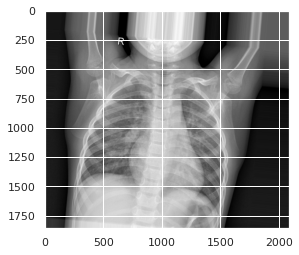

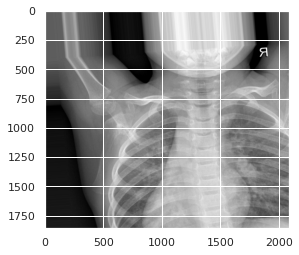

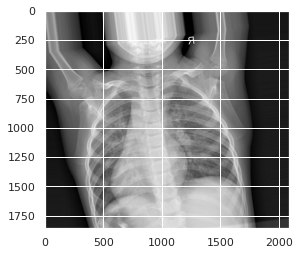

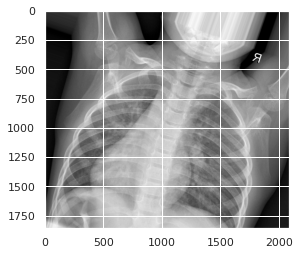

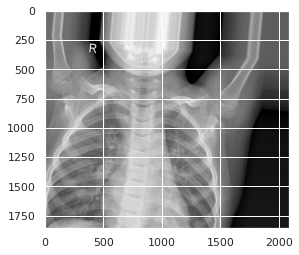

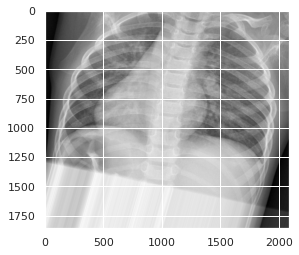

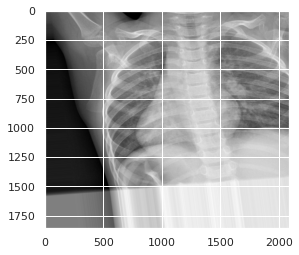

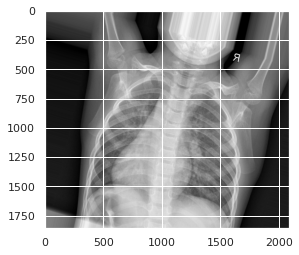

In [ ]:
img = load_img('/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg') 

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0

for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 8:
        break
    plt.imshow(batch[0]/255) 
    plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size= batch_size,
    shuffle = True,
    class_mode='binary')

steps_per_epoch = train_generator.n
test_datagen = ImageDataGenerator()

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'binary')

validation_steps = validation_generator.n

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
train_generator_cat = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size= batch_size,
    shuffle = True,
    class_mode='categorical')

steps_per_epoch = train_generator.n
test_datagen = ImageDataGenerator()

validation_generator_cat = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'categorical')

validation_steps = validation_generator.n

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### **4. Entrenamiento**

Para el proceso de entrenamiento, la arquitectura que se aplicó fue un perceptron multicapa, con dos capas ocultas. Con el fin de realizar una validación experimental de los conceptos vistos en clase, se definieron dos escenarios respecto a la arquitectura: 

1) Con una función Softmax para la capa de salida

2) Con una función Sigmoid para la capa de salida

#### **4.1 Escenario I - Softmax (N)** 

In [ ]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100, 1)),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(2, activation="softmax")
])

In [ ]:
model1.compile(
    optimizer="adam", 
    loss=keras.losses.SparseCategoricalCrossentropy(name="loss"), 
    metrics=["acc"]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

In [ ]:
history1 = model1.fit(
    X_train, y_train,
    epochs=50, validation_data=(X_val, y_val),
    batch_size=500,
    callbacks = callbacks
)

Epoch 1/50
9/9 [==============================] - 1s 77ms/step - loss: 321.8822 - acc: 0.6196 - val_loss: 10.4989 - val_acc: 0.7851
Epoch 2/50
9/9 [==============================] - 0s 47ms/step - loss: 12.4324 - acc: 0.8179 - val_loss: 8.8093 - val_acc: 0.8539
Epoch 3/50
9/9 [==============================] - 0s 46ms/step - loss: 6.6027 - acc: 0.8757 - val_loss: 3.7350 - val_acc: 0.9198
Epoch 4/50
9/9 [==============================] - 0s 45ms/step - loss: 2.8001 - acc: 0.9238 - val_loss: 3.0216 - val_acc: 0.9245
Epoch 5/50
9/9 [==============================] - 0s 48ms/step - loss: 2.6488 - acc: 0.9185 - val_loss: 2.8387 - val_acc: 0.9121
Epoch 6/50
9/9 [==============================] - 0s 46ms/step - loss: 1.8028 - acc: 0.9305 - val_loss: 1.7440 - val_acc: 0.9284
Epoch 7/50
9/9 [==============================] - 0s 46ms/step - loss: 1.7536 - acc: 0.9307 - val_loss: 1.4202 - val_acc: 0.9456
Epoch 8/50
9/9 [==============================] - 0s 45ms/step - loss: 2.5446 - acc: 0.9135 -

In [ ]:
history1 = pd.DataFrame(history1.history)

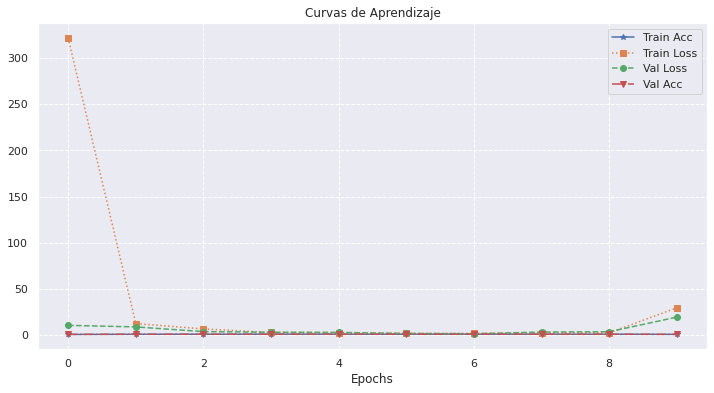

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history1["acc"], "*", label="Train Acc", linestyle="solid")
plt.plot(history1["loss"], "s", label="Train Loss", linestyle="dotted")
plt.plot(history1["val_loss"], "o", label="Val Loss", linestyle="dashed")
plt.plot(history1["val_acc"], "v", label="Val Acc", linestyle="dashdot")
plt.title("Curvas de Aprendizaje")
plt.xlabel("Epochs")
plt.legend(loc="best")
plt.grid(linestyle="--")
plt.show()

In [ ]:
loss1, acc1 = model1.evaluate(X_test, y_test, verbose=1)

20/20 [==============================] - 0s 4ms/step - loss: 59.4204 - acc: 0.6330


In [ ]:
y_pred1 = model1.predict(X_test)

Text(54.260000000000005, 0.5, 'predicted label')

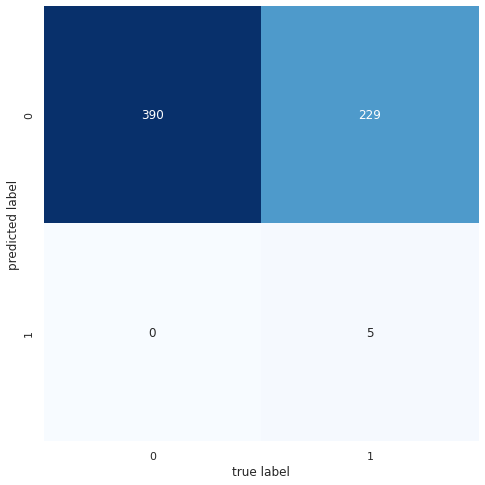

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred1.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
del model1

In [ ]:
def build_model1(activation="relu", units=32):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(100, 100, 1)),
        keras.layers.Dense(
            units * 2, activation=activation, 
            kernel_initializer="he_normal"
        ),
        keras.layers.Dense(
            units, activation=activation, 
            kernel_initializer="he_normal"
        ),
        keras.layers.Dense(2, activation="softmax")
    ])

    loss = keras.losses.SparseCategoricalCrossentropy(name="loss")
    model.compile(optimizer="adam", loss=loss, metrics=["acc"])
    
    return model

In [ ]:
model1 = KerasClassifier(build_fn=build_model1, batch_size=500)

In [ ]:
param_grid = {
    "epochs": [10, 15, 20],
    "activation": ["relu", "elu"],
    "units": [64, 128]
}

In [ ]:
random_search = RandomizedSearchCV(model1, param_grid)

In [ ]:
random_search.fit(X_train, y_train)

Epoch 1/10
7/7 [==============================] - 1s 63ms/step - loss: 384.3243 - acc: 0.5809
Epoch 2/10
7/7 [==============================] - 0s 61ms/step - loss: 89.5933 - acc: 0.6045
Epoch 3/10
7/7 [==============================] - 0s 62ms/step - loss: 30.7833 - acc: 0.6870
Epoch 4/10
7/7 [==============================] - 0s 61ms/step - loss: 11.6537 - acc: 0.7876
Epoch 5/10
7/7 [==============================] - 0s 61ms/step - loss: 7.7926 - acc: 0.8280
Epoch 6/10
7/7 [==============================] - 0s 65ms/step - loss: 6.4840 - acc: 0.8447
Epoch 7/10
7/7 [==============================] - 0s 61ms/step - loss: 3.6837 - acc: 0.8757
Epoch 8/10
7/7 [==============================] - 0s 62ms/step - loss: 2.2680 - acc: 0.8984
Epoch 9/10
7/7 [==============================] - 0s 62ms/step - loss: 4.5907 - acc: 0.8414
Epoch 10/10
2/2 [==============================] - 0s 22ms/step - loss: 3.1153 - acc: 0.8937
Epoch 1/10
7/7 [==============================] - 1s 63ms/step - loss: 437

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f17e4e35cd0>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu', 'elu'],
                                        'epochs': [10, 15, 20],
                                        'units': [64, 128]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
print(f"Mejor puntaje: {random_search.best_score_} usando {random_search.best_params_}")

Mejor puntaje: 0.9476702451705933 usando {'units': 64, 'epochs': 15, 'activation': 'relu'}


#### **4.2 Escenario II - Sigmoid (N)** 

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100, 1)),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(
    optimizer="adam", 
    loss=keras.losses.BinaryCrossentropy(name="binary_crossentropy"), 
    metrics=["acc"]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50, validation_data=(X_val, y_val),
    batch_size=500, 
    callbacks=callbacks
)

Epoch 1/50
9/9 [==============================] - 1s 71ms/step - loss: 210.4370 - acc: 0.6060 - val_loss: 120.1179 - val_acc: 0.7373
Epoch 2/50
9/9 [==============================] - 0s 45ms/step - loss: 54.5947 - acc: 0.6860 - val_loss: 34.5963 - val_acc: 0.5683
Epoch 3/50
9/9 [==============================] - 0s 45ms/step - loss: 17.3230 - acc: 0.7718 - val_loss: 15.2355 - val_acc: 0.8309
Epoch 4/50
9/9 [==============================] - 0s 50ms/step - loss: 10.9644 - acc: 0.8573 - val_loss: 4.9168 - val_acc: 0.9007
Epoch 5/50
9/9 [==============================] - 0s 53ms/step - loss: 7.5811 - acc: 0.8703 - val_loss: 3.8986 - val_acc: 0.9226
Epoch 6/50
9/9 [==============================] - 0s 51ms/step - loss: 4.7779 - acc: 0.9090 - val_loss: 3.3156 - val_acc: 0.9265
Epoch 7/50
9/9 [==============================] - 0s 53ms/step - loss: 3.2164 - acc: 0.9188 - val_loss: 2.6880 - val_acc: 0.9274
Epoch 8/50
9/9 [==============================] - 0s 51ms/step - loss: 2.8108 - acc: 0.9

In [ ]:
history = pd.DataFrame(history.history)

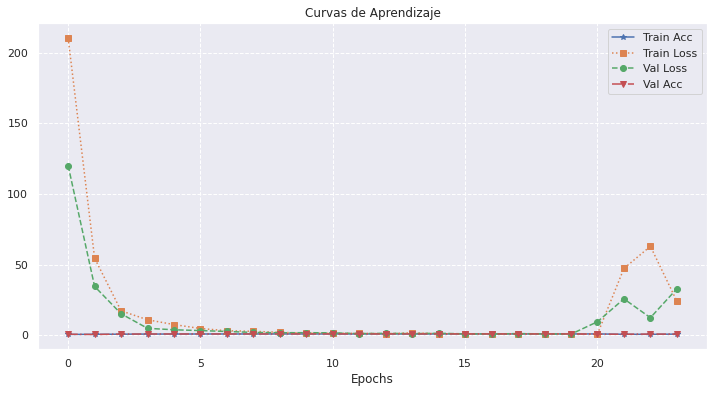

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history["acc"], "*", label="Train Acc", linestyle="solid")
plt.plot(history["loss"], "s", label="Train Loss", linestyle="dotted")
plt.plot(history["val_loss"], "o", label="Val Loss", linestyle="dashed")
plt.plot(history["val_acc"], "v", label="Val Acc", linestyle="dashdot")
plt.title("Curvas de Aprendizaje")
plt.xlabel("Epochs")
plt.legend(loc="best")
plt.grid(linestyle="--")
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)

20/20 [==============================] - 0s 4ms/step - loss: 93.7805 - acc: 0.6474


In [ ]:
y_pred = model.predict(X_test)
y_rounded = [round(x[0]) for x in y_pred]

Text(54.260000000000005, 0.5, 'predicted label')

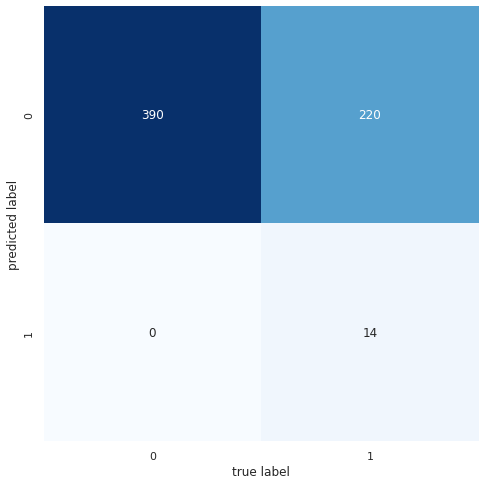

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_rounded)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
del model

In [ ]:
def build_model(activation="relu", units=32):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(100, 100, 1)),
        keras.layers.Dense(
            units * 2, activation=activation, 
            kernel_initializer="he_normal"
        ),
        keras.layers.Dense(
            units, activation=activation, 
            kernel_initializer="he_normal"
        ),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    loss = keras.losses.BinaryCrossentropy(name="binary_crossentropy"), 
    model.compile(optimizer="adam", loss=loss, metrics=["acc"])
    
    return model

In [ ]:
model = KerasClassifier(build_fn=build_model, batch_size=500)

In [ ]:
param_grid1 = {
    "epochs": [10, 15, 20],
    "activation": ["relu", "elu"],
    "units": [64, 128]
}

In [ ]:
random_search1 = RandomizedSearchCV(model, param_grid1)

In [ ]:
random_search1.fit(X_train, y_train)

Epoch 1/20
7/7 [==============================] - 1s 61ms/step - loss: 1001.5501 - acc: 0.6747
Epoch 2/20
7/7 [==============================] - 0s 63ms/step - loss: 561.6348 - acc: 0.5302
Epoch 3/20
7/7 [==============================] - 0s 61ms/step - loss: 394.8578 - acc: 0.6998
Epoch 4/20
7/7 [==============================] - 0s 61ms/step - loss: 222.8755 - acc: 0.6529
Epoch 5/20
7/7 [==============================] - 0s 61ms/step - loss: 89.9139 - acc: 0.6496
Epoch 6/20
7/7 [==============================] - 0s 59ms/step - loss: 63.8608 - acc: 0.7273
Epoch 7/20
7/7 [==============================] - 0s 61ms/step - loss: 39.1972 - acc: 0.7960
Epoch 8/20
7/7 [==============================] - 0s 63ms/step - loss: 22.1616 - acc: 0.8599
Epoch 9/20
7/7 [==============================] - 0s 61ms/step - loss: 12.5716 - acc: 0.8766
Epoch 10/20
7/7 [==============================] - 0s 61ms/step - loss: 8.1702 - acc: 0.9014
Epoch 11/20
7/7 [==============================] - 0s 59ms/step -

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f17db7aec90>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu', 'elu'],
                                        'epochs': [10, 15, 20],
                                        'units': [64, 128]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
print(f"Mejor puntaje: {random_search1.best_score_} usando {random_search1.best_params_}")

#### **4.3 Escenario III - Softmax (DA)** 

In [ ]:
model2 = Sequential()
model2.add(Flatten(input_shape = input_shape))
model2.add(Dense(64, activation="relu", kernel_initializer="he_normal"))
model2.add(Dense(32, activation="relu", kernel_initializer="he_normal"))
model2.add(Dense(2, activation="softmax"))

In [ ]:
model2.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_56 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_168 (Dense)            (None, 64)                1920064   
_________________________________________________________________
dense_169 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_170 (Dense)            (None, 2)                 66        
Total params: 1,922,210
Trainable params: 1,922,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

In [ ]:
history2 = model2.fit(train_generator_cat, epochs= 20, batch_size = 500, callbacks=callbacks)

Epoch 1/20
53/53 [==============================] - 73s 1s/step - loss: 2507055104.0000 - accuracy: 0.7240
Epoch 2/20
53/53 [==============================] - 71s 1s/step - loss: 10253.8994 - accuracy: 0.7360
Epoch 3/20
53/53 [==============================] - 71s 1s/step - loss: 0.6094 - accuracy: 0.7424
Epoch 4/20
53/53 [==============================] - 72s 1s/step - loss: 0.5950 - accuracy: 0.7422
Epoch 5/20
53/53 [==============================] - 74s 1s/step - loss: 0.5860 - accuracy: 0.7422
Epoch 6/20
53/53 [==============================] - 72s 1s/step - loss: 0.5806 - accuracy: 0.7422
Epoch 7/20
53/53 [==============================] - 75s 1s/step - loss: 0.5767 - accuracy: 0.7425
Epoch 8/20
53/53 [==============================] - 74s 1s/step - loss: 0.5745 - accuracy: 0.7425
Epoch 9/20
53/53 [==============================] - 73s 1s/step - loss: 0.5735 - accuracy: 0.7422
Epoch 10/20
53/53 [==============================] - 70s 1s/step - loss: 0.5727 - accuracy: 0.7422
Epoch 

### **5. Validación**

#### **5.1 Escenario I - Softmax** 

In [ ]:
model1 = random_search.best_estimator_

In [ ]:
y_pred1 = model1.predict(X_test)

Text(54.260000000000005, 0.5, 'predicted label')

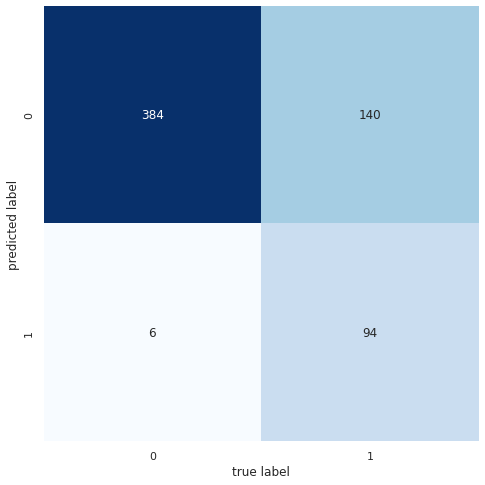

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred1)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
precision_score(y_test, y_pred1, average="weighted")

0.8105152671755724

In [ ]:
recall_score(y_test, y_pred1, average="weighted")

0.7660256410256411

In [ ]:
accuracy_score(y_test, y_pred1)

0.7660256410256411

In [ ]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.73      0.98      0.84       390
           1       0.94      0.40      0.56       234

    accuracy                           0.77       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.81      0.77      0.74       624



#### **5.2 Escenario II - Sigmoid** 

In [ ]:
model = random_search1.best_estimator_

In [ ]:
y_pred = model.predict(X_test)
y_rounded = [round(x[0]) for x in y_pred]

Text(54.260000000000005, 0.5, 'predicted label')

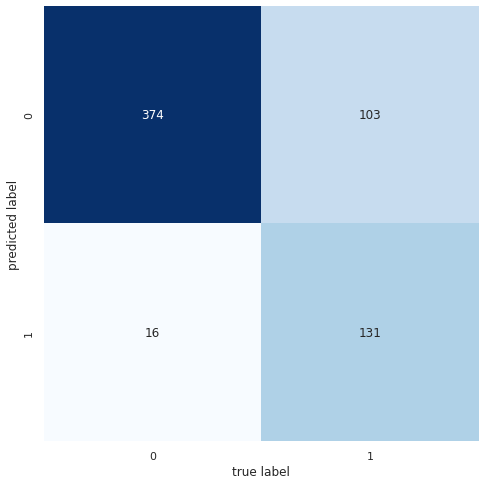

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_rounded)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
precision_score(y_test, y_rounded, average="weighted")

0.8242256021905617

In [ ]:
recall_score(y_test, y_rounded, average="weighted")

0.8092948717948718

In [ ]:
accuracy_score(y_test, y_rounded)

0.8092948717948718

In [ ]:
print(classification_report(y_test, y_rounded))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       390
           1       0.89      0.56      0.69       234

    accuracy                           0.81       624
   macro avg       0.84      0.76      0.78       624
weighted avg       0.82      0.81      0.80       624



#### **5.2 Escenario III - Softmax (DA)** 

In [ ]:
y_pred3 = model2.predict(validation_generator)
y_pred3 = y_pred.argmax(axis=-1)

In [ ]:
Y_test3 = validation_generator.labels

print('Reporte para el modelo III')
names = list(validation_generator.class_indices.keys())
print(classification_report(Y_test3, y_pred3, target_names=names))

Reporte para el modelo III
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(54.260000000000005, 0.5, 'predicted label')

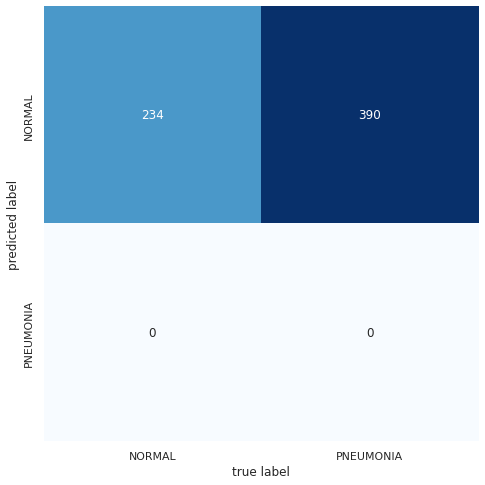

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test3, y_pred3)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=names,
            yticklabels=names)
plt.xlabel('true label')
plt.ylabel('predicted label')

### **6. Analisis de resultados** 

- Podemos ver que la versiones calibradas superan a las versiones con solo earlystoping para el número de epocas en el entrenamiento. 

- Podemos ver que tanto el modelo Softmax normal como el Sigmoid normal tienen a predecir la categoria Neumonia con una mayor frecuencia, sin embargo dada las caracteristicas del negocio, es más importante predecir cuando un paciente tiene neumonia con mayor precisión.

- Podemos ver que el modelo softmax normal tiene una mayor precisión para la clase neumonia y el modelo sigmoid normal a pesar de errar algunas clasificación de neumonia tiene un mayor desempeño para predecir la categoria normal. 

### **7. Conclusiones** 

Con el desarrollo del laboratorio se llegó a las siguientes conclusiones:
- A pesar de que el perceptrón multicapa no es una arquitectura especializada en procesamiento de imágenes, genera unos resultados que permiten entender el aprendizaje de la red con niveles aceptables de predicción.
- La preparación de datos tales como reducción de tamaño de las imágenes permite no solo mejorar la capacidad de predicción de la red, sino también evitar el sobreajuste.
- El número de hiperparametros a optimizar es bastante grande y para esto se utilizó random search para agilizar la generación de los mismos
- Se desarrolló el laboratorio con dos enfoques: 1) Estrictamente con los datos entregados 2) Con la reducción de imágenes  2) Con un proceso de aumentación de datos utilizando imagen generator. Para el primero no se puede correr el entrenamiento por falta de recursos, mientras que en el segundo se desarrolló normalmente el procesamiento al igual que con la generación
- La definición de la configuración de la arquitectura de la red juega un papel fundamental en la etapa de modelamiento, combinado con la definición de hiperparametros hace que el proceso de desarrollo tenga un mayor nivel de complejidad.
- Podemos ver que la aumentación de datos no mejoró el modelo, solo pudo clasificar la clase normal y por eso no se siguió explorando ese método.